# Попытка улучшить показатели лучшей реализации изначальной с ошибкой в ~15.49% RMSE

In [2]:
from IPython.lib.deepreload import reload
from xgboost import train
%load_ext autoreload
%autoreload 2

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PowerTransformer, RobustScaler, QuantileTransformer, PolynomialFeatures, KBinsDiscretizer

from utils.data_manager import DataManager
from utils.model_manager import ModelManager


## 1. Загрузка данных

In [3]:
data_path = 'data/home-data-for-ml-course'
train_data = pd.read_csv(data_path + '/train.csv')
test_data = pd.read_csv(data_path + '/test.csv')

In [4]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_data.shape

(1460, 81)

## 2. Предобработка данных и построение модели через Pipeline

In [6]:
dm = DataManager()

### 2.1. Удаление ненужных столбцов

In [7]:
intuitively_bad_features = [
    'LotShape',  # Общая форма участка
    'LandContour',  # Рельеф участка
    'LotConfig',  # Конфигурация участка
    'LandSlope',  # Уклон участка
    'MiscFeature',
    'MiscVal',
]
# intuitively_bad_features = []

In [8]:
bad_columns = dm.get_all_nan_cols(train_data)
bad_columns.append('Id')
bad_columns.extend(intuitively_bad_features)
bad_columns

['Id',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'MiscFeature',
 'MiscVal']

In [9]:
train_data = train_data.drop(columns=bad_columns)
train_data.head()

# # Удаление столбцов из списка bad_columns и тех, которые не в top_features_catboost
# train_data = train_data.drop(columns=bad_columns)[top_features_catboost]
# train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,Utilities,Neighborhood,Condition1,Condition2,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,AllPub,CollgCr,Norm,Norm,...,0,0,0,NaN,NaN,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,AllPub,Veenker,Feedr,Norm,...,0,0,0,NaN,NaN,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,AllPub,CollgCr,Norm,Norm,...,0,0,0,NaN,NaN,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,AllPub,Crawfor,Norm,Norm,...,0,0,0,NaN,NaN,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,AllPub,NoRidge,Norm,Norm,...,0,0,0,NaN,NaN,12,2008,WD,Normal,250000


In [10]:
train_data.shape

(1460, 74)

### 2.2. Изучаем данные: пытаемся удалить ненужное, либо из нескольких фич сформировать одну новую

In [11]:
train_data.describe(include='all')

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,Utilities,Neighborhood,Condition1,Condition2,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,...,1460.000000,1460.000000,1460.000000,7,281,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,5,NaN,NaN,2,2,2,25,9,8,...,NaN,NaN,NaN,3,4,NaN,NaN,9,6,NaN
top,NaN,RL,NaN,NaN,Pave,Grvl,AllPub,NAmes,Norm,Norm,...,NaN,NaN,NaN,Gd,MnPrv,NaN,NaN,WD,Normal,NaN
freq,NaN,1151,NaN,NaN,1454,50,1459,225,1260,1445,...,NaN,NaN,NaN,3,157,NaN,NaN,1267,1198,NaN
mean,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,...,3.409589,15.060959,2.758904,NaN,NaN,6.321918,2007.815753,NaN,NaN,180921.195890
std,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,...,29.317331,55.757415,40.177307,NaN,NaN,2.703626,1.328095,NaN,NaN,79442.502883
min,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,1.000000,2006.000000,NaN,NaN,34900.000000
25%,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,5.000000,2007.000000,NaN,NaN,129975.000000
50%,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,6.000000,2008.000000,NaN,NaN,163000.000000
75%,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,8.000000,2009.000000,NaN,NaN,214000.000000


In [12]:
# Интерес вызывают две фичи: 	
# •	MiscFeature – Прочие характеристики (не учтенные в других категориях)
# •	MiscVal – Стоимость дополнительных характеристик ($)

In [13]:
# train_data['MiscFeature'].value_counts()

In [14]:
# train_data['MiscVal'].value_counts()

In [15]:
# train_data[train_data['MiscFeature'].notnull()]

In [16]:
# Кажется, ими можно пренебречь, так как всего 54 непустых строки

In [17]:
X, y = dm.split_data_set_to_x_y(train_data, 'SalePrice')
print(X.shape, y.shape)

(1460, 73) (1460,)


### 2.3. Обработка пропущенных значений и нормализация данных через ColumnTransformer и Pipeline

In [18]:
# Получение числовых колонок
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Получение нечисловых колонок (всех остальных)
non_numeric_columns = X.select_dtypes(exclude=['float64', 'int64']).columns

In [19]:
numeric_columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold',
       'YrSold'],
      dtype='object')

In [20]:
non_numeric_columns

Index(['MSZoning', 'Street', 'Alley', 'Utilities', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

In [21]:
# Создаем preprocessor с разными трансформерами для разных типов данных
preprocessor = ColumnTransformer(
    transformers=[
        # Для числовых - импутация средним
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            # ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
            # ('scaler', StandardScaler()),  # Добавляем z-score нормализацию
            # ('selector', SelectFromModel(CatBoostClassifier(iterations=100, verbose=False)))
        ]), numeric_columns),
        
        # Для категориальных - сначала импутация, затем one-hot кодирование
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # 'constant': заполняет константой, которую можно указать через параметр fill_value
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), non_numeric_columns)
    ], 
    sparse_threshold=0,  # Это заставит возвращать dense матрицу вместо sparse
    remainder='drop'  # Все остальные столбцы не будут включены в результат; passthrough - оставить нетронутыми
)

### 2.4. Разбиение данных на обучающую и тестовую выборки

In [22]:
RANDOM_STATE = 42

In [23]:
# 1. Катбуст сам выбирает даныне для валидации, поэтому отсекаем данные только для теста
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

# Проверка размера полученных наборов
print(f'Train size: {len(X_train)}')
print(f'Test size: {len(X_test)}')

Train size: 1022
Test size: 438


### 2.5. Обучение модели

In [24]:
cat_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(iterations=1000, 
                                learning_rate=0.05, 
                                depth=6, 
                                loss_function='RMSE', 
                                verbose=0, 
                                random_seed=RANDOM_STATE,
                                ))
])

# Обучение модели
cat_pipeline.fit(X_train, y_train)

# Предсказание и оценка
y_pred_cat = cat_pipeline.predict(X_test)
mse_cat = mean_squared_error(y_test, y_pred_cat)
rmse_cat = root_mean_squared_error(y_test, y_pred_cat)
r2_cat = r2_score(y_test, y_pred_cat)

print("\n=== CatBoost ===")
print(f'MSE: {mse_cat:.4f}')
print(f'RMSE: {rmse_cat:.4f}')
print(f'R² (коэффициент детерминации): {r2_cat:.4f}')
# Относительная ошибка (в процентах от среднего значения целевой переменной)
mean_target = np.mean(y_test)
print(f'Относительная ошибка (RMSE/mean): {rmse_cat/mean_target*100:.2f}%')

# Используем кросс-валидацию (cross-validation), чтобы результаты были надежными и не зависели от случайного разбиения.
scores = cross_val_score(cat_pipeline, X, y, scoring='neg_root_mean_squared_error', cv=5)
rmse_scores = -scores
print("Средний RMSE на кросс-валидации:", rmse_scores.mean())


=== CatBoost ===
MSE: 541555259.0227
RMSE: 23271.3399
R² (коэффициент детерминации): 0.9224
Относительная ошибка (RMSE/mean): 12.93%
Средний RMSE на кросс-валидации: 25867.99820262165


Топ-10 значимых признаков:
                   Feature  Importance
3         num__OverallQual   23.511287
15          num__GrLivArea   12.529051
12           num__1stFlrSF    5.588522
25         num__GarageCars    4.904865
8          num__BsmtFinSF1    4.748828
22       num__TotRmsAbvGrd    4.208785
2             num__LotArea    3.207135
23         num__Fireplaces    2.722541
5           num__YearBuilt    2.571181
13           num__2ndFlrSF    2.055183
26         num__GarageArea    1.883669
6        num__YearRemodAdd    1.733929
11        num__TotalBsmtSF    1.625924
201    cat__KitchenQual_TA    1.622137
167   cat__BsmtExposure_Gd    1.460129
27         num__WoodDeckSF    1.257423
4         num__OverallCond    1.217207
160       cat__BsmtQual_Gd    1.213650
221  cat__GarageFinish_Unf    1.175111
24        num__GarageYrBlt    1.144850


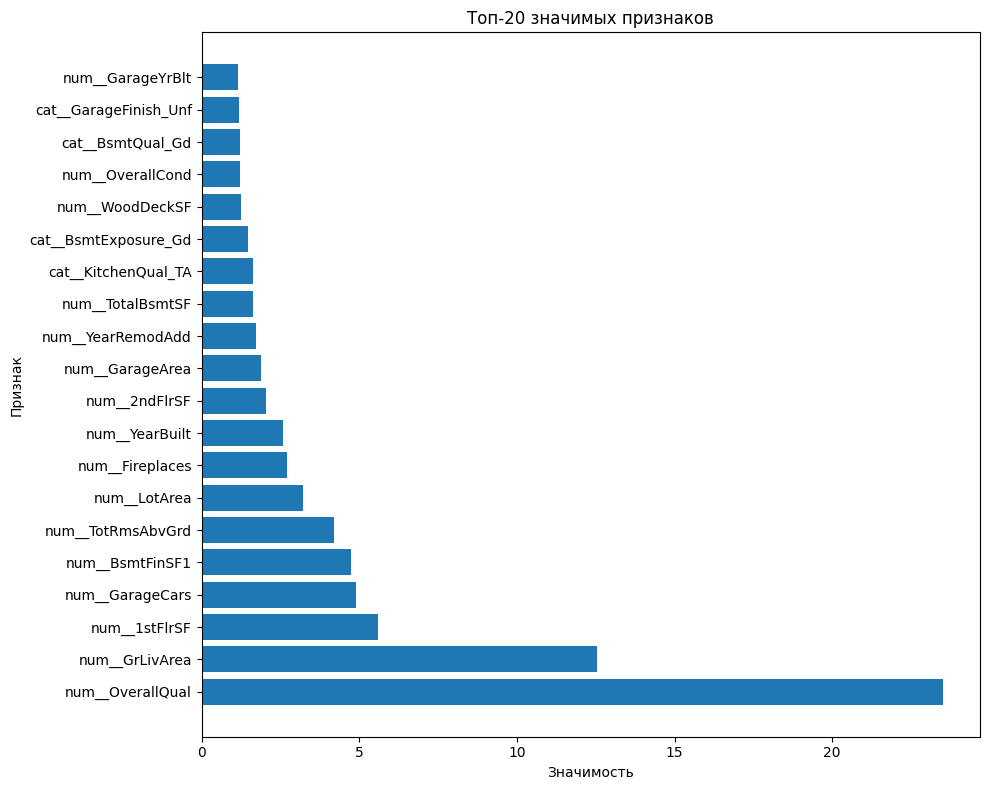

In [101]:
# Получение значимости признаков
feature_importance = cat_pipeline.named_steps['model'].get_feature_importance()

# Способ 1: Используя встроенные возможности получения имен признаков (если доступно)
try:
    # Попытка получить имена признаков напрямую из pipeline
    feature_names = cat_pipeline.named_steps['preprocessor'].get_feature_names_out()
except:
    # Если не получилось, используем нумерацию
    feature_names = [f'Feature_{i}' for i in range(len(feature_importance))]

# Создание и сортировка DataFrame со значимостью признаков
importance_df = pd.DataFrame({
    'Feature': feature_names[:len(feature_importance)],
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Вывод топ-10 признаков
print("Топ-10 значимых признаков:")
print(importance_df.head(20))

# Визуализация (если не установлен seaborn, используем matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(importance_df.head(20)['Feature'], importance_df.head(20)['Importance'])
plt.title('Топ-20 значимых признаков')
plt.xlabel('Значимость')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

## Формируем Submission файл для Kaggle обучив модель на 100% данных

In [25]:
# Используем сейчас Cross-validation, потому что:
# 	•	нужно надёжно сравнить несколько разных моделей или гиперпараметров и понять, какая модель стабильнее и лучше в целом.
# 	•	хотим избежать случайных удач или провалов, связанных с конкретным разбиением на train/test.
# 	•	выбираем модель или гиперпараметры, которые потом будешь использовать для финального сабмишна на Kaggle.
# Делаем эту оценку, чтобы в дальнейших блокнотах-улучшениях сравнивать более корректно.

from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores = cross_val_score(cat_pipeline, X, y, scoring='neg_root_mean_squared_error', cv=cv)
rmse_scores = -scores
print("Средний RMSE на стабильной кросс-валидации:", rmse_scores.mean())

Средний RMSE на стабильной кросс-валидации: 27099.062707634053


In [24]:
cat_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', '...
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x1094a9c10>)])

In [25]:
X_submission = test_data.drop(columns=bad_columns)
X_submission.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,Utilities,Neighborhood,Condition1,Condition2,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,AllPub,NAmes,Feedr,Norm,...,0,0,120,0,NaN,MnPrv,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,AllPub,NAmes,Norm,Norm,...,0,0,0,0,NaN,NaN,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,AllPub,Gilbert,Norm,Norm,...,0,0,0,0,NaN,MnPrv,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,AllPub,Gilbert,Norm,Norm,...,0,0,0,0,NaN,NaN,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,AllPub,StoneBr,Norm,Norm,...,0,0,144,0,NaN,NaN,1,2010,WD,Normal


In [26]:
y_submission = cat_pipeline.predict(X_submission)
y_submission

array([128825.63364516, 167291.6590769 , 185714.95526545, ...,
       169096.96288633, 123328.30283398, 230852.97585396])

In [27]:
submission = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': y_submission
})
submission.set_index('Id', inplace=True)
submission.head()

,SalePrice
Id,
1461,128825.633645
1462,167291.659077
1463,185714.955265
1464,194504.430481
1465,188129.389195


In [28]:
submission.to_csv('submission_v4.csv')

## Итоги

Как итог экспериментов текущих:
- очень сильное влияние на результат оказывается исключени маловлияющих фич. НО, если исключить больше нужного, например, исключить все, кроме топ20 фич, которые сам катбуст выделил как самые влияющие, то точность значительно упадет!
- очень сильно влияет количество данных в обучащем сете и в тестовом. Например, если делим 90 на обучение и 10 на тест, то ошибка сильно возрастает (оверфиттинг очевидный), если делим 50 на 50 - тоже плохо. Идеально: 70 на 30, лучший результат.
- можно задирать в потолок количество итераций катбуста, это ничего не даст, кроме оверфиттинга
- значительно улучшило показатель точности уменьшение коэффициента обучения с 0.1 до 0.05
- неплохой прирост точности дала замена ('imputer', SimpleImputer(strategy='mean')) на mean с median у числовых признаков!
- особо никакого влияния (даже ухудшение было) не произвело добавление полиномиальных фич.
- не забываем перед отправкой на kaggle обучить модель на всех данных!

Лучшие показатели на сегодня: 
R² (коэффициент детерминации): 0.9224
Относительная ошибка (RMSE/mean): 12.93%